In [1]:
import pandas as pd
import numpy as np
import requests
import pickle
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx

%matplotlib inline

# Seaborn Settings
import seaborn as sns
sns.set()
sns.set_style('white')

/Users/ryang52/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# GeocodeScans

This file takes scanned TF files and geocodes each entry.

# Load Files

In [2]:
# 2006 NJ Truckers Friend
NJ2006 = pd.read_csv("../../scans/_processed/2006-NJ-all.csv")

# US States
states = gpd.read_file("../../data/raw/cb_2018_us_state_500k/cb_2018_us_state_500k.shp")

# HPMS (NJ)
highways = gpd.read_file("../../data/HPMS4NBER/Universe_11_16/2016_state/newjersey2016/NewJersey.shp")

In [3]:
# NJ Mile Markers

njmm = gpd.read_file("../../data/raw/statelevel/nj/NJ_Milepost10ths_shp/TRAN_NJ_MP_TENTH_2021_shp.shp")

There are roughly three types of addresses:
    
    1. Traditional address (street number + street name)
    2. Highway exits
    3. Highway Mile Marker
    
I will geocode each separately.

In [65]:
# Strip Parenthetical Phrases
# There are many addresses with parenthetical phrases describing
# where the space is relative to another road, location, etc.
# These tend to confuse Google Maps

odd = lambda x: x % 2 == 1
even = lambda x: x % 2 == 0

def cleanAddrParen(s):
    slist = s.replace(')','(').split('(')
    return ' '.join([slist[x].strip() for x in range(len(slist)) if even(x)]).strip()

# If there are multiple locations listed, use the first exit
# Typically only true for locations at multiple exits (of highway intersection)

def getFirstOption(s):
    return s.split('/')[0]

NJ2006['address_clean'] = NJ2006.address.apply(cleanAddrParen).apply(getFirstOption)

# Sort rows into Exits and Mile Markers
NJ2006['Exit'] = NJ2006.address_clean.apply(lambda x: 'exit' in x.lower())
NJ2006['MM'] = NJ2006.address_clean.apply(lambda x: 'mm' in x.lower())

In [66]:
#nj_tiger = gpd.read_file("../../data/raw/census/tl_2022_34_prisecroads/tl_2022_34_prisecroads.shp")
#nj_tiger.plot()
#nj_tiger.FULLNAME.unique()

# Traditional Address

I will geocode these using Google Places API

In [67]:
# Filter for Traditional Addr's
tradAddresses = NJ2006[(NJ2006.Exit==False) & (NJ2006.MM==False)].copy()

# Construct Long Address Formats for Querying

# Format = Street Name, City, State Zip, USA
formula = lambda idx: tradAddresses.address_clean[idx] + ", " + \
    tradAddresses.city[idx].split(', ')[0] +", "+ \
    tradAddresses.state[idx]+" "+tradAddresses.city[idx].split(', ')[1]+\
    ", USA"

queries = [formula(idx) for idx in tradAddresses.index]

# Add Queries back to original table
NJ2006['addr'] = ""
NJ2006.loc[(NJ2006.Exit==False) & (NJ2006.MM==False), 'addr'] = queries

In [68]:
print(len(queries))

67


In [ ]:
# Query Google Maps
from dotenv import load_dotenv
import os


load_dotenv()
api_key = os.getenv("API_KEY")


330 NJ 503 S, Carlstadt, NJ 07073, USA
688 NJ 503 S, Carlstadt, NJ 07072, USA
US 1-9 NB, Elizabeth, NJ 07202, USA
391 US 9 SB & Gordons-Corner Rd, Freehold, NJ 07728, USA
145 NJ 551 S, Gloucester City, NJ 08030, USA
US 1-9 & Duncan Ave, Jersey City, NJ 07306, USA
US 1-9 SB & Sip Ave, Jersey City, NJ 07306, USA
US 1-9 & Wood Ave, Linden, NJ 07036, USA
US 1-9 & Delancy W, Newark, NJ 07105, USA


In [ ]:

payload={}
headers = {}
out_array = []
data_array = []

for query in queries:

    # Construct Google Maps API
    key = os.getenv("API_KEY")
    url = "https://maps.googleapis.com/maps/api/place/textsearch/json?query="+query+"&key="+key

    # Make API Call
    response = requests.request("GET", url, headers=headers, data=payload)

    # Format output as JSON
    data = json.loads(response.text)
    data_array.append(data)
    
    # Pull out results
    try:
        res = data['results'][0]
        
        # Pull address & lat lon
        res_addr = res['formatted_address']
        res_geo = res['geometry']['location']

        # Form row in dataframe
        out = [query, res_addr, res_geo['lat'], res_geo['lng']]

        # Add row to output array
        out_array.append(out)
    except:
        print(query)
        continue

In [70]:
# Pull out results and format addresses / locations

out_array = []
for (i_data,data) in enumerate(data_array):
    # Pull out results
    try:
        res = data['results'][0]
    except:
        print(i_data, data, queries[i_data])
        continue

    # Pull address & lat lon
    res_addr = res['formatted_address']
    res_geo = res['geometry']['location']

    # Form row in dataframe
    out = [queries[i_data], res_addr, res_geo['lat'], res_geo['lng']]

    # Add row to output array
    out_array.append(out)

3 {'html_attributions': [], 'results': [], 'status': 'ZERO_RESULTS'} 330 NJ 503 S, Carlstadt, NJ 07073, USA
4 {'html_attributions': [], 'results': [], 'status': 'ZERO_RESULTS'} 688 NJ 503 S, Carlstadt, NJ 07072, USA
19 {'html_attributions': [], 'results': [], 'status': 'ZERO_RESULTS'} US 1-9 NB, Elizabeth, NJ 07202, USA
26 {'html_attributions': [], 'results': [], 'status': 'ZERO_RESULTS'} 391 US 9 SB & Gordons-Corner Rd, Freehold, NJ 07728, USA
28 {'html_attributions': [], 'results': [], 'status': 'ZERO_RESULTS'} 145 NJ 551 S, Gloucester City, NJ 08030, USA
35 {'html_attributions': [], 'results': [], 'status': 'ZERO_RESULTS'} US 1-9 & Duncan Ave, Jersey City, NJ 07306, USA
36 {'html_attributions': [], 'results': [], 'status': 'ZERO_RESULTS'} US 1-9 SB & Sip Ave, Jersey City, NJ 07306, USA
39 {'html_attributions': [], 'results': [], 'status': 'ZERO_RESULTS'} US 1-9 & Wood Ave, Linden, NJ 07036, USA
44 {'html_attributions': [], 'results': [], 'status': 'ZERO_RESULTS'} US 1-9 & Delancy W,

In [71]:
# Construct output dataframe
out_df = pd.DataFrame(out_array, columns = ['addr','fmt_addr','lat','lng'])

# Merge into NJ2006
NJ2006_coded = pd.merge(NJ2006, out_df,how='left', on='addr')
NJ2006_coded['geometry'] = gpd.points_from_xy(NJ2006_coded.lng, NJ2006_coded.lat, crs="EPSG:4269")

NJ2006_coded = NJ2006_coded[~pd.isnull(NJ2006_coded.lat)]

# Parse Exit Numbers

We will use open street maps, and query based on (1) city, and (2) exit number.

In [72]:
exits = NJ2006[NJ2006.Exit].copy()

In [73]:
# Replace entries where the NJTK merges onto I-something

In [74]:
address_clean_list = []
junction_list = []
label_list = []

for idx in range(exits.shape[0]):

    row = exits.iloc[idx]

    # Place = City, State
    placeLoc = row.city.split(',')[0] + ", " + row.state + ", " + "USA"

    # Extract Exit = text after "Exit"    
    try:
        exitNo = row.address_clean.split('Exit')[1].replace(' ','')
    except:
        print(row.address_clean, " ", placeLoc, " failed to parse")
        continue
        
    try:
        # Find all Junctions within 5km of the place centroid
        #junctions = osmnx.features.features_from_place(placeLoc, {'highway':'motorway_junction'})
        radius = 10000
        junctions = osmnx.features.features_from_point(osmnx.geocode(placeLoc), {'highway':'motorway_junction'},
                                  dist=radius)
        junctions.ref = junctions.ref.fillna('')
        
        #print("FO")
        # Filter on exit location, and take the first one
        if exitNo in junctions.ref.unique():    
            correct_junction = junctions[junctions.ref==exitNo].iloc[0]
            junction_list.append(correct_junction)
        elif sum(junctions.ref.apply(lambda x: exitNo in x)) > 0:
            # Use any exit that has part of the exit number (4 \in 4B)
            correct_junction = junctions[junctions.ref.apply(lambda x: exitNo in x)].iloc[0]
            junction_list.append(correct_junction)
        else:
            # Use just the first part of the exit number
            exitNo = row.address_clean.split('Exit')[1].split(' ')[0]
            correct_junction = junctions[junctions.ref.apply(lambda x: exitNo in x)].iloc[0]
            junction_list.append(correct_junction)

        address_clean_list.append(row.address_clean)
        label_list.append(row.label)

    except:
        print(row.address_clean, " ", placeLoc, " failed to locate")
        continue

junctionDf = pd.concat([pd.DataFrame(x).transpose() for x in junction_list])
junctionDf['address_clean'] = address_clean_list
junctionDf['label'] = label_list

exitsWithGeo = pd.merge(exits, junctionDf[['address_clean','geometry','label']], how='left')

# Parse Mile Markers

In [75]:
# Filter for Mile Markers
mileMarker = NJ2006[(NJ2006.Exit==False) & (NJ2006.MM==True)].copy()

mileMarker['road_name'] = mileMarker.address_clean.apply(lambda x: x.split('MM')[0].strip())
mileMarker['mm_value'] = mileMarker.address_clean.apply(lambda x: float(x.split('MM')[-1].strip().split(' ')[0]))

idx = 0
row = mileMarker.iloc[idx]

# Place = City, State
placeLoc = row.city.split(',')[0] + ", " + row.state + ", " + "USA"
print(placeLoc)

nj_data = gpd.read_file("../../data/raw/statelevel/nj/NJ_Milepost10ths_shp/TRAN_NJ_MP_TENTH_2021_shp.shp")
nj_data.SLD_NAME.unique()
junctions

roadDict={'NJTP':'NJTPK', 'Garden State Pkwy':'GSP'}

njtp = highways[highways.ROUTE_NAME=='NJTPK']

# Geocode using highway segment data

point_array = []

for i in range(mileMarker.shape[0]):

    # Filter for the correct road
    road_name = mileMarker.road_name.iloc[i]
    road = highways[highways.ROUTE_NAME==roadDict[road_name]]    
    road = road.sort_values(['ROUTE_NAME','BEGIN_POIN'])

    # Mile Marker
    mm = mileMarker.mm_value.iloc[i]

    # Corrections: NJ Turnpike becomes 
    
    # segment starts before MM & ends after MM
    th = 0.0
    first_segment = road[(road.BEGIN_POIN<=mm+th) & (road.END_POINT>=mm-th)]
    print(road_name, mm, first_segment.shape[0])
    
    try:
        point = first_segment.geometry.iloc[0]
        point_array.append([road_name, mm,point])
    except:
        point_array.append([road_name, mm,np.nan])
        print("FAIL")



mmDf = pd.DataFrame(point_array)
mmDf.columns = ['road_name','mm_value','geometry']
mmDf = gpd.GeoDataFrame(mmDf)

mmDf = mmDf.groupby(['road_name','mm_value']).first().reset_index()

mileMarker_Geo = pd.merge(mileMarker, mmDf, how='left', on=['road_name','mm_value'])



#first_segment

Cherry Hill, NJ, USA
NJTP 30.2 2
NJTP 71.7 0
FAIL
Garden State Pkwy 76.0 2
NJTP 58.7 0
FAIL
NJTP 59.0 0
FAIL
NJTP 39.4 2
NJTP 5.4 2
NJTP 5.4 2
NJTP 115.0 0
FAIL
NJTP 111.6 0
FAIL
NJTP 92.9 0
FAIL
NJTP 92.2 0
FAIL


# Assemble Entire Dataset

In [76]:
cols = ['city','label','overnight_lot','geometry']

# Concatenate 3 categories together
fullGeoDf = pd.concat([mileMarker_Geo[cols],
           NJ2006_coded[cols],
          exitsWithGeo[cols]])
fullGeoDf = gpd.GeoDataFrame(fullGeoDf[~pd.isnull(fullGeoDf.geometry)])

fullGeoDf['geometry'] = fullGeoDf.geometry.centroid
fullGeoDf['lng'] = fullGeoDf.geometry.apply(lambda x: x.x)
fullGeoDf['lat'] = fullGeoDf.geometry.apply(lambda x: x.y)



In [77]:
# Write to file
fullGeoDf.to_file("../../data/derived/geospatial/truckersfriend/2006_NJ.shp")

/var/folders/yq/q_st6bp10d14vvbvcqfd76k40000gp/T/ipykernel_12813/3753387859.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  fullGeoDf.to_file("../../data/derived/geospatial/truckersfriend/2006_NJ.shp")


In [20]:
# Read back from file
fullGeoDf = gpd.read_file("../../data/derived/geospatial/truckersfriend/2006_NJ.shp")

In [21]:
# For the ones without geocoding, use the city centroid

fullGeoDfExpanded = pd.merge(NJ2006[['city','label','address','overnight_lot']], fullGeoDf, how='left')

def f(x):
    return osmnx.geocode(x.split(',')[0] + ' NJ')

latlns = fullGeoDfExpanded[pd.isnull(fullGeoDfExpanded.geometry)].city.apply(f)

lats = latlns.apply(lambda x:x[0])
lngs = latlns.apply(lambda x:x[1])

fullGeoDfExpanded.loc[pd.isnull(fullGeoDfExpanded.geometry),'lng'] = lngs
fullGeoDfExpanded.loc[pd.isnull(fullGeoDfExpanded.geometry),'lat'] = lats

mask = pd.isnull(fullGeoDfExpanded.geometry)

pts = gpd.points_from_xy(fullGeoDfExpanded[mask].lng, fullGeoDfExpanded[mask].lat, crs="EPSG:4269")
fullGeoDfExpanded.loc[pd.isnull(fullGeoDfExpanded.geometry),'geometry'] = pts

fullGeoDfExpanded['filled'] = mask

fullGeoDfExpanded['overnight_lot_clean'] = fullGeoDfExpanded.overnight_lot.fillna('None')
fullGeoDfExpanded.overnight_lot_clean = fullGeoDfExpanded.overnight_lot_clean.apply(lambda x: x.replace('$',''))

fullGeoDfExpanded = gpd.GeoDataFrame(fullGeoDfExpanded)

In [25]:
fullGeoDfExpanded.to_file("../../data/derived/geospatial/truckersfriend/2006_NJ_expanded.shp")

/var/folders/7r/xx0s96591dv5zgwy3c657pd4z3qm35/T/ipykernel_55273/4121153100.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  fullGeoDfExpanded.to_file("../../data/derived/geospatial/truckersfriend/2006_NJ_expanded.shp")


In [127]:
#fullGeoDfExpanded[mask & (fullGeoDfExpanded.filled)]

In [219]:
# Plot Results

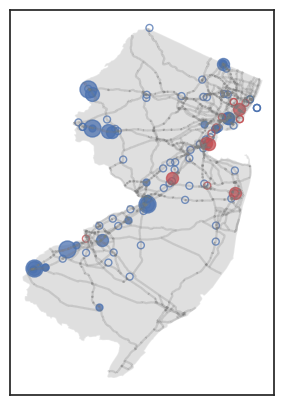

In [131]:
fi,ax=plt.subplots(figsize=(10,5))

# Plot State Outline
states[states.NAME=='New Jersey'].plot(ax=ax, alpha=0.25, color='grey')

# Plot highway system
highways[(highways.F_SYSTEM == 1)].plot(ax=ax, alpha=0.25, color='grey')
highways[(highways.F_SYSTEM == 2)].plot(ax=ax, alpha=0.25, color='grey')
highways[(highways.F_SYSTEM == 3)].plot(ax=ax, alpha=0.25, color='grey')

# Plot Stops
mask = (fullGeoDf.lng > -76) & (fullGeoDf.lat < 41.5)
fullGeoDf[mask & (fullGeoDf.overnight_lot_clean=='None')].plot(ax=ax, marker='o', facecolors='none', edgecolors='b', markersize=25,
                                                              alpha=0.75)

fullGeoDf[mask & (fullGeoDf.overnight_lot_clean=='S')].plot(ax=ax, marker='o', facecolors='b', edgecolors='b', markersize=25,
                                                              alpha=0.75)
fullGeoDf[mask & (fullGeoDf.overnight_lot_clean=='M')].plot(ax=ax, marker='o', facecolors='b', edgecolors='b', markersize=75,
                                                              alpha=0.75)
fullGeoDf[mask & (fullGeoDf.overnight_lot_clean=='L')].plot(ax=ax, marker='o', facecolors='b', edgecolors='b', markersize=100,
                                                              alpha=0.75)
fullGeoDf[mask & (fullGeoDf.overnight_lot_clean=='XL')].plot(ax=ax, marker='o', facecolors='b', edgecolors='b', markersize=150,
                                                              alpha=0.75)

mask = (fullGeoDfExpanded.lng > -76) & (fullGeoDfExpanded.lat < 41.5)

fullGeoDfExpanded[mask & (fullGeoDfExpanded.filled) & 
    (fullGeoDfExpanded.overnight_lot_clean=='None')].plot(ax=ax, marker='o', facecolors='none', edgecolors='r', markersize=25,
                                                              alpha=0.75)

fullGeoDfExpanded[mask & (fullGeoDfExpanded.filled) & 
    (fullGeoDfExpanded.overnight_lot_clean=='M')].plot(ax=ax, marker='o', facecolors='r', edgecolors='r', markersize=75,
                                                              alpha=0.75)

ax.set_xticks([])
ax.set_yticks([])

fi.savefig("../../output/plots/scans_nj2006_parking.jpg",dpi=500,bbox_inches='tight')

In [122]:
mask = (fullGeoDf.lng > -76) & (fullGeoDf.lat < 41.5)
fullGeoDf[mask & (fullGeoDf.overnight_lot_clean=='XL')]#.plot(facecolor='b')

,city,label,overnight_lot,geometry,lng,lat,overnight_lot_clean
0,"Bloomsbury, 08804",TravelCenters of America,XL$,POINT (-75.07041 40.65992),-75.070411,40.659925,XL
3,"Bordentown, 08505",Petro Stopping Center #14,XL$,POINT (-74.69412 40.12926),-74.694116,40.129261,XL
6,"Carney's Point, 08069",Flying J Travel Plaza #0500067,XL,POINT (-75.47877 39.68524),-75.478766,39.685238,XL
10,"Columbia, 07832",TravelCenters of America,XL,POINT (-75.09987 40.93212),-75.099873,40.932117,XL
24,"Paulsboro, 08066",TravelCenters of America (Exxon),XL,POINT (-75.24946 39.81713),-75.249456,39.817132,XL


In [123]:
tyupeof9fullGeoDfExpanded[mask & (fullGeoDfExpanded.filled)]#.plot(facecolor='b')

/var/folders/yq/q_st6bp10d14vvbvcqfd76k40000gp/T/ipykernel_12813/1046250633.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fullGeoDfExpanded[mask & (fullGeoDfExpanded.filled)]#.plot(facecolor='b')


,city,label,overnight_lot,geometry,lng,lat,overnight_lot_clean,filled
16,"Clinton, 08809",Johnny's Truck Stop (Citgo),L$,POINT (-74.96457 40.63583),-74.964575,40.635829,L,False
17,"Clinton, 08809",Clinton Truck Stop,M,POINT (-74.93722 40.63340),-74.937218,40.633395,M,False
34,"Elizabeth, 07202",Easy Gas Station,NaN,POINT (-74.21070 40.66399),-74.210701,40.663992,None,True
56,"Jersey City, 07306",Duncan Avenue Truck Stop (Gulf),NaN,POINT (-74.04745 40.72157),-74.047455,40.721568,None,True


# 2016

In [16]:
# 2006 NJ Truckers Friend
NJ2016 = pd.read_csv("../../scans/_processed/2016-NJ-all.csv")

In [6]:
def clean_address(x):
    # Strip Parenthetical Phrases
    # There are many addresses with parenthetical phrases describing
    # where the space is relative to another road, location, etc.
    # These tend to confuse Google Maps
    
    odd = lambda x: x % 2 == 1
    even = lambda x: x % 2 == 0
    
    def cleanAddrParen(s):
        slist = s.replace(')','(').split('(')
        return ' '.join([slist[x].strip() for x in range(len(slist)) if even(x)]).strip()
    
    # If there are multiple locations listed, use the first exit
    # Typically only true for locations at multiple exits (of highway intersection)
    
    def getFirstOption(s):
        return s.split('/')[0]
    
    x['address_clean'] = x.address.apply(cleanAddrParen).apply(getFirstOption)
    
    # Sort rows into Exits and Mile Markers
    x['Exit'] = x.address_clean.apply(lambda x: 'exit' in x.lower())
    x['MM'] = x.address_clean.apply(lambda x: 'mm' in x.lower())

    return x

In [7]:
def makeQueries(df):

    # Filter for Traditional Addr's
    tradAddresses = df[(df.Exit==False) & (df.MM==False)].copy()
    
    # Construct Long Address Formats for Querying
    
    # Format = Street Name, City, State Zip, USA
    formula = lambda idx: tradAddresses.address_clean[idx] + ", " + \
        tradAddresses.city[idx].split(' (')[0] +", "+ \
        tradAddresses.state[idx]+" "+tradAddresses.city[idx].split(' (')[1].strip(')')+\
        ", USA"
    
    queries = [formula(idx) for idx in tradAddresses.index]
    
    # Add Queries back to original table
    tradAddresses['addr'] = queries

    return (tradAddresses, queries)



In [ ]:
def queryGoogleMaps(queries):
    
    # Query Google Maps
    
    payload={}
    headers = {}
    out_array = []
    data_array = []
    
    for query in queries:
    
        # Construct Google Maps API
        key = key
        url = "https://maps.googleapis.com/maps/api/place/textsearch/json?query="+query+"&key="+key
    
        # Make API Call
        response = requests.request("GET", url, headers=headers, data=payload)
    
        # Format output as JSON
        data = json.loads(response.text)
        data_array.append(data)
        
        # Pull out results
        try:
            res = data['results'][0]
            
            # Pull address & lat lon
            res_addr = res['formatted_address']
            res_geo = res['geometry']['location']
    
            # Form row in dataframe
            out = [query, res_addr, res_geo['lat'], res_geo['lng']]
    
            # Add row to output array
            out_array.append(out)
        except:
            print(query)
            continue

    return out_array

In [9]:
def createAddressedGDF(out_array, tradAddresses):

    # Construct output dataframe
    out_df = pd.DataFrame(out_array, columns = ['addr','fmt_addr','lat','lng'])
    
    # Merge into NJ2006
    tradAddresses_coded = pd.merge(tradAddresses, out_df,how='left', on='addr')
    tradAddresses_coded['geometry'] = gpd.points_from_xy(tradAddresses_coded.lng, tradAddresses_coded.lat, crs="EPSG:4269")
    
    tradAddresses_coded = gpd.GeoDataFrame(tradAddresses_coded[~pd.isnull(tradAddresses_coded.lat)])
    return tradAddresses_coded

In [10]:
## Addresses

# Clean addresses
NJ2016 = clean_address(NJ2016)
df = NJ2016.copy()

# Construct queries
tradAddresses, queries = makeQueries(df)

# Run Queries
out_array = queryGoogleMaps(queries)

# Construct GeoDataFrame
tradAddresses_coded = createAddressedGDF(out_array, tradAddresses)

391 US 9 SB & Gordons-Comer Rd, Freehold, NJ 07728, USA
90 US 30 N & US 206, Hammonton, NJ 08037, USA
US 1-9 & Duncan Ave W, Jersey City, NJ 07306, USA
US 1-9 SB & Sip Ave, Jersey City, NJ 07306, USA
701 US 1-9 SB, Linden, NJ 07036, USA
US 1-9 & Delancy W, Newark, NJ 07105, USA


In [11]:

def constructExits(df):

    exits = df[df.Exit].copy()
    address_clean_list = []
    junction_list = []
    label_list = []
    
    for idx in range(exits.shape[0]):
    
        row = exits.iloc[idx]
    
        # Place = City, State
        placeLoc = row.city.split(' ')[0] + ", " + row.state + ", " + "USA"
    
        # Extract Exit = text after "Exit"    
        try:
            exitNo = row.address_clean.split('Exit')[1].replace(' ','')
        except:
            print(row.address_clean, " ", placeLoc, " failed to parse")
            continue
            
        try:
            # Find all Junctions within 5km of the place centroid
            #junctions = osmnx.features.features_from_place(placeLoc, {'highway':'motorway_junction'})
            radius = 10000
            junctions = osmnx.features.features_from_point(osmnx.geocode(placeLoc), {'highway':'motorway_junction'},
                                      dist=radius)
            junctions.ref = junctions.ref.fillna('')
            
            # Filter on exit location, and take the first one
            if exitNo in junctions.ref.unique():    
                correct_junction = junctions[junctions.ref==exitNo].iloc[0]
                junction_list.append(correct_junction)
            elif sum(junctions.ref.apply(lambda x: exitNo in x)) > 0:
                # Use any exit that has part of the exit number (4 \in 4B)
                correct_junction = junctions[junctions.ref.apply(lambda x: exitNo in x)].iloc[0]
                junction_list.append(correct_junction)
            else:
                # Use just the first part of the exit number
                exitNo = row.address_clean.split('Exit')[1].split(' ')[0]
                correct_junction = junctions[junctions.ref.apply(lambda x: exitNo in x)].iloc[0]
                junction_list.append(correct_junction)
    
            address_clean_list.append(row.address_clean)
            label_list.append(row.label)
    
        except:
            print(row.address_clean, " ", placeLoc)
            continue
    
    juncationDf = pd.concat([pd.DataFrame(x).transpose() for x in junction_list])
    juncationDf['address_clean'] = address_clean_list
    juncationDf['label'] = label_list
    
    exitsWithGeo = pd.merge(exits, juncationDf[['address_clean','geometry','label']], how='left')
    return exitsWithGeo


In [12]:
exitsWithGeo = constructExits(df)

In [13]:
exitsWithGeo

,row_id,city,label,phone,address,overnight_lot,state,address_clean,Exit,MM,geometry
0,3,Bloomsbury (08804),Pilot Travel Center #280,908-479-6443,I-78 Exit 7 (NJ 173),S,NJ,I-78 Exit 7,True,False,POINT (-75.0704108 40.6599248)
1,4,Bloomsbury (08804),TA Bloomsbury #048 (Exxon),908-479-4136,I-78 Exit 7 (NJ 173),L,NJ,I-78 Exit 7,True,False,POINT (-75.0704108 40.6599248)
2,5,Bordentown (08505),Turnpike Valero,609-291-0555,NJTP Exit 7 (US 206 S),NaN,NJ,NJTP Exit 7,True,False,POINT (-74.6941157 40.129261)
3,6,Bordentown (08505),Love's Travel Stop #404,609-324-1005,NJTP Exit 7/I-295 Exit 56 NB/52A SB,L,NJ,NJTP Exit 7,True,False,POINT (-74.6941157 40.129261)
4,7,Bordentown (08505),Petro Bordentown #314,609-298-6070,NJTP Exit 7/l-295 Exit 56 NB/52A SB,XL$,NJ,NJTP Exit 7,True,False,POINT (-74.6941157 40.129261)
5,10,Carney’s Point (08069),G Fuel,856-351-1085,I-295 Exit 2 B (E to 362 US 40 N),L,NJ,I-295 Exit 2 B,True,False,POINT (-74.8691097 39.0044477)
6,11,Carney’s Point (08069),Pilot Travel Center #253,856-299-5701,I-295 Exit 2 B (NJ 140 E),S,NJ,I-295 Exit 2 B,True,False,POINT (-74.8691097 39.0044477)
7,12,Carney’s Point (08069),Flying J Travel Plaza #688,856-351-0080,I-295 Exit 2 C (NJ 140 W),XL,NJ,I-295 Exit 2 C,True,False,POINT (-74.8691097 39.0044477)
8,13,Carney's Point (08069),Sunoco,856-299-9300,I-295 Exit 2 C (NJ 140 W),L,NJ,I-295 Exit 2 C,True,False,POINT (-74.8691097 39.0044477)
9,17,Clinton (08827),Pilot Travel Center #190,908-735-7711,I-78 Exit 12 (NJ 173),M,NJ,I-78 Exit 12,True,False,POINT (-74.964575 40.6358285)


In [14]:
def constructMileMarkers(df, highways):

    # Filter for Mile Markers
    mileMarker = df[(df.Exit==False) & (df.MM==True)].copy()
    
    mileMarker['road_name'] = mileMarker.address_clean.apply(lambda x: x.split('MM')[0].strip())
    mileMarker['mm_value'] = mileMarker.address_clean.apply(lambda x: float(x.split('MM')[-1].strip().split(' ')[0]))
    
    roadDict={'NJTP':'NJTPK', 
              'Garden State Pkwy':'GSP', 
              'NJ 444':'GSP',
             'I-95':'I-95'}
    
    # Geocode using highway segment data
    point_array = []
    
    for i in range(mileMarker.shape[0]):
    
        # Filter for the correct road
        road_name = mileMarker.road_name.iloc[i]
        road = highways[highways.ROUTE_NAME==roadDict[road_name]]    
        road = road.sort_values(['ROUTE_NAME','BEGIN_POIN'])
    
        mm = mileMarker.mm_value.iloc[i]
        # segment starts before MM & ends after MM
        th = 0.0
        first_segment = road[(road.BEGIN_POIN<=mm+th) & (road.END_POINT>=mm-th)]
        print(road_name, mm, first_segment.shape[0])
        
        try:
            point = first_segment.geometry.iloc[0]
            point_array.append([road_name, mm,point])
        except:
            point_array.append([road_name, mm,np.nan])
    
    mmDf = pd.DataFrame(point_array)
    mmDf.columns = ['road_name','mm_value','geometry']
    mmDf = gpd.GeoDataFrame(mmDf)
    
    mmDf = mmDf.groupby(['road_name','mm_value']).first().reset_index()
    
    mileMarker_Geo = pd.merge(mileMarker, mmDf, how='left', on=['road_name','mm_value'])
    return mileMarker_Geo

In [15]:
mileMarker_Geo = constructMileMarkers(df, highways)

NJTP 30.2 2
NJTP 71.7 0
NJTP 78.7 0
NJ 444 76.0 2
NJTP 58.7 0
NJTP 58.7 0
NJ 444 100.0 2
NJTP 39.4 2
NJTP 5.4 2
NJTP 5.4 2
NJ 444 41.0 2
I-95 116.0 0
NJ 444 18.0 2
I-95 111.6 0
NJTP 92.9 0


In [17]:
def buildFullGeo(tradAddresses_coded, exitsWithGeo, mileMarker_Geo):
    cols = ['city','label','overnight_lot','geometry']

    # Concatenate 3 categories together
    fullGeoDf = pd.concat([mileMarker_Geo[cols],
               tradAddresses_coded[cols],
              exitsWithGeo[cols]])
    fullGeoDf = gpd.GeoDataFrame(fullGeoDf[~pd.isnull(fullGeoDf.geometry)])
    
    fullGeoDf['geometry'] = fullGeoDf.geometry.centroid
    fullGeoDf['lng'] = fullGeoDf.geometry.apply(lambda x: x.x)
    fullGeoDf['lat'] = fullGeoDf.geometry.apply(lambda x: x.y)

    fullGeoDf['overnight_lot_clean'] = fullGeoDf.overnight_lot.fillna('None')
    fullGeoDf.overnight_lot_clean = fullGeoDf.overnight_lot_clean.apply(lambda x: x.replace('$',''))

    return fullGeoDf

In [18]:
fullGeoDf = buildFullGeo(tradAddresses_coded, exitsWithGeo, mileMarker_Geo)

In [ ]:
# Write to file
fullGeoDf.to_file("../../data/derived/geospatial/truckersfriend/2006_NJ.shp")

In [26]:
fullGeoDfExpanded = gpd.read_file("../../data/derived/geospatial/truckersfriend/2016_NJ_expanded.shp")

In [27]:
fullGeoDf = fullGeoDfExpanded[fullGeoDfExpanded.filled==0].copy()
del fullGeoDf['filled']

In [28]:
# For the ones without geocoding, use the city centroid

fullGeoDfExpanded = pd.merge(NJ2016[['city','label','address','overnight_lot']], fullGeoDf, how='left')

def f(x):
    return osmnx.geocode(x.split(',')[0] + ' NJ')

# Construct City Lat-Longs
latlns = fullGeoDfExpanded[pd.isnull(fullGeoDfExpanded.geometry)].city.apply(f)
lats = latlns.apply(lambda x:x[0])
lngs = latlns.apply(lambda x:x[1])

fullGeoDfExpanded.loc[pd.isnull(fullGeoDfExpanded.geometry),'lng'] = lngs
fullGeoDfExpanded.loc[pd.isnull(fullGeoDfExpanded.geometry),'lat'] = lats

# Create Points
mask = pd.isnull(fullGeoDfExpanded.geometry)
pts = gpd.points_from_xy(fullGeoDfExpanded[mask].lng, fullGeoDfExpanded[mask].lat, crs="EPSG:4269")
fullGeoDfExpanded.loc[pd.isnull(fullGeoDfExpanded.geometry),'geometry'] = pts

fullGeoDfExpanded['filled'] = mask

fullGeoDfExpanded['overnight_lot_clean'] = fullGeoDfExpanded.overnight_lot.fillna('None')
fullGeoDfExpanded.overnight_lot_clean = fullGeoDfExpanded.overnight_lot_clean.apply(lambda x: x.replace('$',''))

fullGeoDfExpanded = gpd.GeoDataFrame(fullGeoDfExpanded)

In [31]:
fullGeoDfExpanded.to_file("../../data/derived/geospatial/truckersfriend/2016_NJ_expanded.shp")

/var/folders/7r/xx0s96591dv5zgwy3c657pd4z3qm35/T/ipykernel_55273/1027106940.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  fullGeoDfExpanded.to_file("../../data/derived/geospatial/truckersfriend/2016_NJ_expanded.shp")


[]

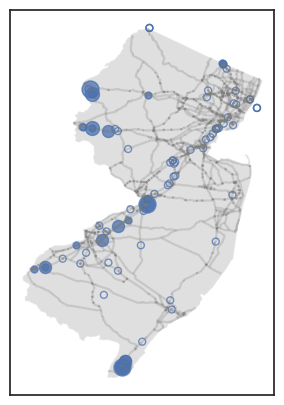

In [19]:
fi,ax=plt.subplots(figsize=(10,5))

# Plot State Outline
states[states.NAME=='New Jersey'].plot(ax=ax, alpha=0.25, color='grey')

# Plot highway system
highways[(highways.F_SYSTEM == 1)].plot(ax=ax, alpha=0.25, color='grey')
highways[(highways.F_SYSTEM == 2)].plot(ax=ax, alpha=0.25, color='grey')
highways[(highways.F_SYSTEM == 3)].plot(ax=ax, alpha=0.25, color='grey')

# Plot Stops
mask = (fullGeoDf.lng > -76) & (fullGeoDf.lat < 41.5)
fullGeoDf[mask & (fullGeoDf.overnight_lot_clean=='None')].plot(ax=ax, marker='o', facecolors='none', edgecolors='b', markersize=25,
                                                              alpha=0.75)

fullGeoDf[mask & (fullGeoDf.overnight_lot_clean=='S')].plot(ax=ax, marker='o', facecolors='b', edgecolors='b', markersize=25,
                                                              alpha=0.75)
fullGeoDf[mask & (fullGeoDf.overnight_lot_clean=='M')].plot(ax=ax, marker='o', facecolors='b', edgecolors='b', markersize=75,
                                                              alpha=0.75)
fullGeoDf[mask & (fullGeoDf.overnight_lot_clean=='L')].plot(ax=ax, marker='o', facecolors='b', edgecolors='b', markersize=100,
                                                              alpha=0.75)
fullGeoDf[mask & (fullGeoDf.overnight_lot_clean=='XL')].plot(ax=ax, marker='o', facecolors='b', edgecolors='b', markersize=150,
                                                              alpha=0.75)

ax.set_xticks([])
ax.set_yticks([])

#fi.savefig("../../output/plots/scans_nj2016_parking.jpg",dpi=500,bbox_inches='tight')

# Pennsylvania

In [4]:
# Load File

with open("../../scans/_processed/pages-not-clean/2006-180.txt","r") as f:
    penn = f.readlines()

In [33]:
# cleanPage
# Loads `fn` and cleans the addresses
# Constructs output dataframe with city/zip/name/phone/addr

def cleanPage(fn):

    with open(fn,"r") as f:
        penn = f.readlines()
        
    # Strip out extra lines
    penn = [i for i in penn if i != '\n']
    
    # Pull out individual pieces of the strings
    
    zipNames = [penn[i] for i in range(len(penn)) if i%2==0]
    phoneAddr = [penn[i] for i in range(len(penn)) if i%2==1]
    
    city = [i.split(' ')[0] for i in zipNames]
    zipc = [i.split(' ')[1] for i in zipNames]
    name = [' '.join(i.strip().split(' ')[2:]) for i in zipNames]
    
    phones = [i.split(' ')[0] for i in phoneAddr]
    addr = [' '.join(i.strip().split(' ')[1:]) for i in phoneAddr]
    
    # Simple Cleaning of Addr
    
    # (if floating -, then replace with "I-")
    addr = [i.replace(' -',' I-') for i in addr]
    addr = [i.replace('-','I-') if i[0]=='-' else i for i in addr ]
    
    # Replace '1-' with 'I-'
    addr = [i.replace('1-','I-') if i[0]=='1' else i for i in addr]
    
    # if a paren opens, close it
    addr = [i + ')' if i.count('(') > i.count(')') else i for i in addr]
    
    # Construct DataFrame
    outDf = pd.DataFrame(columns = ['city','zip','name','phone','addr'])
    outDf['city'] = city
    outDf['zip'] = zipc
    outDf['name'] = name
    outDf.loc[range(len(phones)), 'phone'] = phones
    outDf.loc[range(len(phones)), 'addr'] = addr

    return outDf

In [36]:
import glob

In [39]:
glob.glob("../../scans/_processed/pages-not-clean/2016*")

['../../scans/_processed/pages-not-clean/2016-211.txt',
 '../../scans/_processed/pages-not-clean/2016-210.txt',
 '../../scans/_processed/pages-not-clean/2016-212.txt',
 '../../scans/_processed/pages-not-clean/2016-164.txt',
 '../../scans/_processed/pages-not-clean/2016-213.txt',
 '../../scans/_processed/pages-not-clean/2016-161.txt',
 '../../scans/_processed/pages-not-clean/2016-216.txt',
 '../../scans/_processed/pages-not-clean/2016-214.txt',
 '../../scans/_processed/pages-not-clean/2016-162.txt',
 '../../scans/_processed/pages-not-clean/2016-163.txt',
 '../../scans/_processed/pages-not-clean/2016-215.txt',
 '../../scans/_processed/pages-not-clean/2016-209.txt']

In [40]:
pages = []

for fn in glob.glob("../../scans/_processed/pages-not-clean/2016*"):
    pages.append(cleanPage(fn))

In [42]:
pa2016 = pd.concat(pages)

In [44]:
pa2016.to_csv("../../scans/_processed/2016-PA-all-automated.csv")

In [32]:
fn = "../../scans/_processed/pages-not-clean/2006-185.txt"

with open(fn,"r") as f:
    penn = f.readlines()
    
# Strip out extra lines
penn = [i for i in penn if i != '\n']

# Pull out individual pieces of the strings

# Even rows should be zip + names
zipNames = [penn[i] for i in range(len(penn)) if i%2==0]

# odd rows should be phone + address
phoneAddr = [penn[i] for i in range(len(penn)) if i%2==1]

city = [i.split(' ')[0] for i in zipNames]
zipc = [i.split(' ')[1] for i in zipNames]
name = [' '.join(i.strip().split(' ')[2:]) for i in zipNames]

phones = [i.split(' ')[0] for i in phoneAddr]
addr = [' '.join(i.strip().split(' ')[1:]) for i in phoneAddr]

# Simple Cleaning of Addr

# (if floating -, then replace with "I-")
addr = [i.replace(' -',' I-') for i in addr]
addr = [i.replace('-','I-') if i[0]=='-' else i for i in addr ]

# Replace '1-' with 'I-'
addr = [i.replace('1-','I-') if i[0]=='1' else i for i in addr]

# if a paren opens, close it
addr = [i + ')' if i.count('(') > i.count(')') else i for i in addr]

# Construct DataFrame
outDf = pd.DataFrame(columns = ['city','zip','name','phone','addr'])
outDf['city'] = city
outDf['zip'] = zipc
outDf['name'] = name
outDf.loc[range(len(phones)), 'phone'] = phones
outDf.loc[range(len(phones)), 'addr'] = addr

,city,zip,name,phone,addr
0,Ighoemakersville,19555,Shoemakersville Texaco,610-562-0988,PAGIN(3 miSof-78Exit29A)
1,Shrewsbury,17349,Cigarette Cellar #22 eripsctey Ae,Me,ecco as 1-83 Exit4(PAB51)
2,Britton,16479,Penn Slation Travel Plaza (Exxon),124-872-4050,I-70 Exit 49 (Smithton Rd eat)
3,Frow,Shoe,16874 Reese Truck Stop (Exxon),814-387-6203,I-80 Exit 147 (PA 144)
4,Fomerset,15507,South Somerset Plaza #7076 (Sunoco),g14-445-4025,I-70I-76 (PATP) MM 112 EB
5,Bile,College,16801 Minit Mart (Citgo),614-238-1391,913 W College Ave een
6,Bockertown,18083,T&C MiniMart (Shel),610-746-4390,PA 33 & PA 191
7,Bybertsville,18222,Pilot Travel Center #298 ae,670-788-3262,I-80 Exit 256 (PA 93 ss)
8,Tamaqua,18252,Fegley Oil Co (Mobil) f,p70-386-4151,PA 309 (2 miS oftown) Si
9,Town,Hill,17267 Town Hill Travel Plaza (Sunoco),814-735-3850,I-70 Exit 156 (PA 643)


range(0, 19)

In [20]:
penn

['Ighoemakersville 19555 Shoemakersville Texaco\n',
 '610-562-0988 PAGIN(3 miSof-78Exit29A)\n',
 'Shrewsbury 17349 Cigarette Cellar #22 eripsctey Ae\n',
 'Me ecco as 1-83 Exit4(PAB51)\n',
 'Britton 16479 Penn Slation Travel Plaza (Exxon)\n',
 '124-872-4050 1-70 Exit 49 (Smithton Rd eat\n',
 'Frow Shoe 16874 Reese Truck Stop (Exxon)\n',
 '814-387-6203 1-80 Exit 147 (PA 144)\n',
 'Fomerset 15507 South Somerset Plaza #7076 (Sunoco)\n',
 'g14-445-4025 -70-76 (PATP) MM 112 EB\n',
 'Bile College 16801 Minit Mart (Citgo)\n',
 '614-238-1391 913 W College Ave een\n',
 'Bockertown 18083 T&C MiniMart (Shel)\n',
 '610-746-4390 PA 33 & PA 191\n',
 'Bybertsville 18222 Pilot Travel Center #298 ae\n',
 '670-788-3262 1-80 Exit 256 (PA 93 ss\n',
 'Tamaqua 18252 Fegley Oil Co (Mobil) f\n',
 'p70-386-4151 PA 309 (2 miS oftown) Si\n',
 'Town Hill 17267 Town Hill Travel Plaza (Sunoco)\n',
 '814-735-3850 I-70 Exit 156 (PA 643\n',
 'tevose 19047 North Neshaminy Plaza (Sunoco)\n',
 '215-357-9725 1-276 (PATP) M